# 1. 데이터 로드 및 전처리

In [1]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


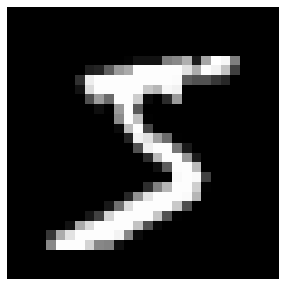

In [2]:
# 샘플 이미지 출력
import matplotlib.pyplot as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx], cmap='gray')
    plt.axis('off')
    plt.show()

plot_image(x_train, 0)

In [3]:
print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

0 255
0 255


In [4]:
# 정규화
x_train = x_train / 255.0
x_test = x_test / 255.0

In [5]:
print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

0.0 1.0
0.0 1.0


- mnist 데이터셋은 색상 채널이 1개
- CNN 모델에 주입하기 위해 색상을 나타내는 채널 추가
- 가장 마지막 축에 채널 추가: `[..., tf.newaxis]`
- 가장 앞에 차원 추가: `[tf.newaxis, ...]`
- 두번째에 차원 추가: `[:, tf.newaxis, :, :]`

In [6]:
# 채널 추가
print(x_train.shape, x_test.shape)

x_train_in = x_train[..., tf.newaxis]
x_test_in = x_test[..., tf.newaxis]

print(x_train_in.shape, x_test_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


# 2. Sequential API로 모델 생성 및 학습
- 합성곱 레이어 1개, 풀링 레이어 1개
- 최종 분류 Dense 레이어 -> Flatten 층을 추가하여 1차원 배열로 펼쳐줌
- 합성곱 -> Conv2D 레이어, (3, 3) 크기의 서로 다른 32가지 종류의 커널, ReLU 활성화 함수
- 풀링 레이어 -> (2, 2) 크기로 최대 풀링(max pooling)
- 마지막은 10개 클래스 분류 -> sofrmax 활성화 함수


In [7]:
# Sequential API 사용하여 샘플 모델 생성
model = tf.keras.Sequential([
    # Convolution 적용(32 필터)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2, 2), name='pool'),
    # Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

- 앞서 정의한 모델 구조에 옵티마이저, 손실함수, 평가지표 설정 -> 컴파일 -> 모델 인스턴스 생성
- `fit()` 메소드에 훈련 셋과 검증 셋 주입, epoch=10

In [11]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# 모델 훈련
history = model.fit(x_train_in, y_train,
          validation_data=(x_test_in, y_test),
          epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0167 - acc: 0.9949 - val_loss: 0.0581 - val_acc: 0.9843
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0139 - acc: 0.9961 - val_loss: 0.0570 - val_acc: 0.9846
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0120 - acc: 0.9963 - val_loss: 0.0580 - val_acc: 0.9840
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0099 - acc: 0.9970 - val_loss: 0.0605 - val_acc: 0.9842
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0083 - acc: 0.9978 - val_loss: 0.0609 - val_acc: 0.9840
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0071 - acc: 0.9981 - val_loss: 0.0652 - val_acc: 0.9854
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.0687 - val_acc: 0.9838
Epoch 8/10
1875/1875 [==============================] - 4s 2ms

- `evalutae()` 메소드를 모델 인스턴스에 적용: 모델의 학습된 가중치 사용하여 손실과 평가지표 계산

In [12]:
model.evaluate(x_test_in, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0706 - acc: 0.9845


[0.07063430547714233, 0.984499990940094]

- 훈련 결과를 history에 저장
- 이를 가지고 예측 오차와 정확도를 그리는 함수 정의 후 실행

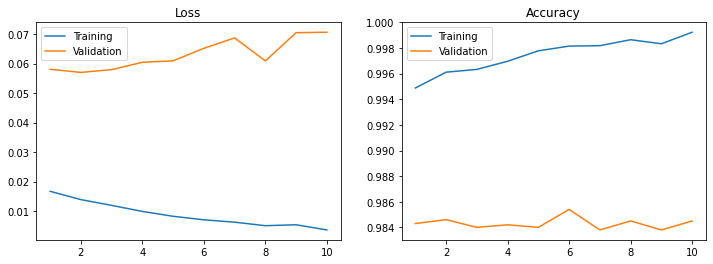

In [16]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['acc'], history.history['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')
    
    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 10)

- 2 epoch부터 검증 손실이 줄어들지 않음
- 이후로는 과대적합

# 3. 모델 구조 파악
- `summary()` 메소드 적용 시 모델의 구조를 요약하여 보여줌

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 26, 26, 32)        320       
_________________________________________________________________
pool (MaxPooling2D)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


- (28, 28, 1) 형태의 입력 텐서가 Conv2D를 거치면서 (26, 26, 32) 형태로 변환
- (3, 3) 크기의 합성 곱 필터를 사용하기 때문에 이미지 가로, 세로 크기가 2씩 줄어듦(패딩이 없음)
- 서로 다른 32개의 필터를 적용했기 때문에 (26, 26) 크기의 특성맵이 32개 생성됨
- 즉 (28, 28, 1) 이미지에 서로 다른 32개의 커널을 적용해서 32가지 종류의 피처를 추출
--- 
- (2, 2) 크기의 풀링 레이어 적용 -> 이미지 크기가 절반으로 줄어듦
- 따라서 풀링 레이어 거치면 (13, 13, 32) 텐서로 변환
- Flatten 층에서 3차원 텐서를 1차원 텐서로 펼치면 5408개 (13 * 13 * 32) 원소를 갖는 1차원 벡터가 됨
---
- 이 벡터를 출력 노드 10개인 Dense 레이어로 보내면 최종 분류 값을 예측해 출력

In [18]:
# 입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

- 입력 텐서는 (None, 28, 28, 1) 형태
    - 가장 앞에 있는 축(axis=0)의 None 값은 배치 크기가 들어오는 위치
    - 배치 크기로 어떤 값이든 가능하다는 의미

In [19]:
# 출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

- 10개의 노드를 갖는 1차원 벡터 형태

In [20]:
# 레이어
model.layers

- 파이썬 리스트 형태로 레이어 객체를 담아서 보여줌

In [21]:
# 첫 번째 레이어 선택
model.layers[0]

- 따라서 인덱싱 가능

In [22]:
# 첫 번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

- 각 레이어에 입력되는 텐서를 따로 선택하는 것도 가능
- 모델의 입력 데이터가 그대로 들어가기 때문에 (None, 28, 28, 1) 형태를 가짐

In [23]:
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

- Conv2D 레이어를 거치면 픽셀 사이즈가 2씩 줄어들고 채널 개수가 32개로 늘어남
- (None, 26, 26, 32) 형태

In [24]:
# 첫 번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-1.93171537e+00, -7.81547964e-01,  3.72144103e-01,
            2.72445917e-01, -5.57032943e-01, -1.22653198e+00,
            1.03547819e-01,  8.17694440e-02,  2.19529524e-01,
            1.42205492e-01, -3.19793612e-01,  1.47832498e-01,
           -6.08171582e-01,  1.07822669e+00, -1.59329975e+00,
            4.41713452e-01,  4.20003891e-01, -3.17359030e-01,
           -9.71360683e-01,  3.96933615e-01, -6.47580445e-01,
            5.58650017e-01,  1.53845504e-01, -1.83383012e+00,
            5.71174443e-01, -8.59601736e-01, -3.18332642e-01,
           -7.16999173e-03, -1.12152445e+00, -6.73900902e-01,
           -6.97946846e-01, -8.66549909e-01]],
 
         [[-8.56039822e-01, -7.17214346e-01,  1.76080525e-01,
           -5.66220343e-01, -4.19370055e-01,  7.09768906e-02,
            7.40416527e-01,  5.69846272e-01,  5.78682482e-01,
           -4.72029150e-01,  1.21632382e-01,  4.77263093e-01,
           

- 첫 번째 변수 'conv/kernel:0': 커널(합성곱 필터) 행렬의 가중치
- 두 번째 변수 'conv/bias:0': 각 커널의 상수항(bias)


In [25]:
# 첫 번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-1.93171537e+00, -7.81547964e-01,  3.72144103e-01,
           2.72445917e-01, -5.57032943e-01, -1.22653198e+00,
           1.03547819e-01,  8.17694440e-02,  2.19529524e-01,
           1.42205492e-01, -3.19793612e-01,  1.47832498e-01,
          -6.08171582e-01,  1.07822669e+00, -1.59329975e+00,
           4.41713452e-01,  4.20003891e-01, -3.17359030e-01,
          -9.71360683e-01,  3.96933615e-01, -6.47580445e-01,
           5.58650017e-01,  1.53845504e-01, -1.83383012e+00,
           5.71174443e-01, -8.59601736e-01, -3.18332642e-01,
          -7.16999173e-03, -1.12152445e+00, -6.73900902e-01,
          -6.97946846e-01, -8.66549909e-01]],

        [[-8.56039822e-01, -7.17214346e-01,  1.76080525e-01,
          -5.66220343e-01, -4.19370055e-01,  7.09768906e-02,
           7.40416527e-01,  5.69846272e-01,  5.78682482e-01,
          -4.72029150e-01,  1.21632382e-01,  4.77263093e-01,
           8.49868059e-02,  

- 커널 가중치의 shape이 (3, 3, 1, 32)
    - (3, 3): 필터의 크기
    - (1): 입력층의 채널 개수
    - (32): 출력층의 채널 개수
- layer[0]의 커널 학습(업데이트) 가능한 파라미터 수는 3 * 3 * 1 * 32 = 288개

In [26]:
# 첫 번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.19520098, -0.09698068, -0.17951113, -0.23490047, -0.55686164,
       -0.05468486, -0.06318072, -0.19821346,  0.00908872, -0.13949381,
       -0.01091184, -0.21285093, -0.16640787,  0.02193335,  0.19233978,
       -0.31856155, -0.4085551 , -0.22136514, -0.16656367, -0.4961758 ,
       -0.25397825, -0.0084539 , -0.44404906, -0.03094084, -0.62415695,
       -0.40369493, -0.49555454,  0.        , -0.21870878, -0.29144773,
       -0.3572076 , -0.00845318], dtype=float32)>

- 상수항(bias) 가중치 shape은 (32, ): 출력층의 채널 수
- layer[0]의 총 학습 가능한 파라미터 수는 288 + 32 = 320개

In [27]:
# 레이어 이름 사용하여 레이어 선택
model.get_layer('conv')

- 레이어의 이름을 사용하여 해당 레이어를 선택할 수도 있음

In [29]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가(첫 번째, 두 번째 레이어)
activator = tf.keras.Model(inputs=model.input,
                           outputs=[layer.output for layer in model.layers[:2]])
activations = activator.predict(x_train_in[0][tf.newaxis, ...])
len(activations)

2

- 모델에 입력 데이터를 넣어주고, 첫 번째 레이어와 두 번째 레이어의 출력을 최종 출력으로 갖는 `activator` 모델 정의
- 첫 번째 샘플에 대해 각 레이어 출력을 예측

In [32]:
# 첫 번째 레이어(conv) 출력층
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

- Conv2D 레이어의 출력
- (1, 26, 26, 32)의 텐서 형태
- 1은 입력 이미지의 개수 의미(샘플이 1개)

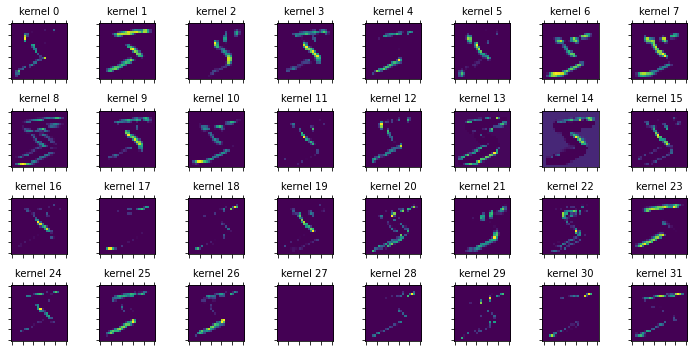

In [34]:
# Convolution 시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(conv_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

- 첫 번째 레이어에서 출력되는 특성맵 이미지를 32개 커널별로 구분하여 시각화
- 출력 이미지의 특징이 조금씩 차이가 있음
    - 각 커널은 입력 이미지로부터 서로 다른 피처(특징)을 추출하는 역할

In [35]:
# 두 번째 레이어(pool) 출력층
pooling_activation = activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


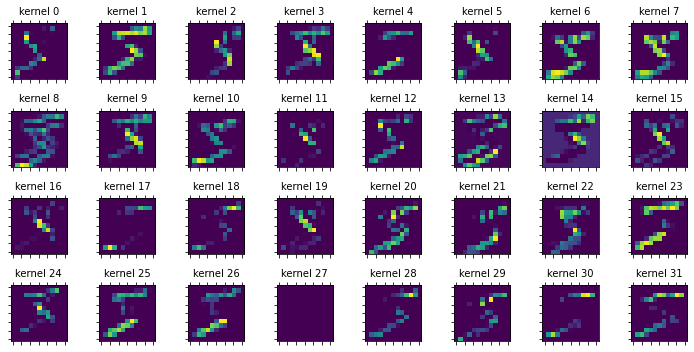

In [36]:
# 시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(pooling_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

- Conv2D 출력 이미지에 비해 화소 크기가 굵어진 것을 볼 수 있음
- 최대 풀링은 인근 픽셀을 모아 최대값으로 고정하기 때문
- 픽셀 수는 줄이면서 특징을 더욱 강하게 드러낼 수 있음